code adpated from 
code/MNF/notebooks/test_alphafold/identifyNovelPPI_PPIandComplex_visulisation.ipynb



In [1]:
#@title Display 3D structure {run: "auto"}
import os
import sys
import pickle
import py3Dmol
import glob
import multiprocessing as mp
import matplotlib.pyplot as plt

from Bio.PDB import PDBParser

import pandas as pd
import json

import numpy as np


# import networkx as nx 

In [2]:
%reload_ext autoreload
%autoreload 2

sys.path.append('../src/utilities/') #

from pdb_benchmark import get_STRING1105_pdb_interact

from py3Dmol_functions import show_pdb
# from py3Dmol_functions import py3Dmol_addOneLine
# from py3Dmol_functions import py3Dmol_addLines
# from py3Dmol_functions import get_pro_stuc_chainRes_dict
# from py3Dmol_functions import tripleMSA_get_pro_stuc_chainRes_dict
# from py3Dmol_functions import map_topRankingBetValue_list_to_PDB_CACoords

# from py3Dmol_functions import show_alphfold_plot

# from collect_topCoEvos import get_topRankingBetValue_dict
# from collect_topCoEvos import get_topRankingBetValue_dict_PosInSingleMSA
# from collect_topCoEvos import get_topRanking_CoEvo_file

# import xpdb

# from STRING_benchmark import get_STRING1105_physical_interact
from STRING_benchmark import get_string_score_dict

from parse_AlphaFold_output import get_interprotein_maxcontactprob_from_processedalphafoldnpz
# from parse_AlphaFold_output import get_interprotein_mincm_from_pdb

# from plot_graph_network import return_goodTriplets

# from tripleMSA_relatedFunctions import prepareTrileMSA



In [3]:
def isStringProIDs_ribosome(pp,ecoli_proteinNames_dict):
    for p in pp:
        if ecoli_proteinNames_dict[p][0:2] == "rp": 
            return True
    return False


def collect_interprotein_maxprob12(novelPP,colab_outputPath,Query_allPPI_allInfo_dict):
    argument_toget_interprotein_prob12=[[colab_outputPath,".custom_"+model_key+"_distogram.npz"]+list((p1,p2)+Query_allPPI_allInfo_dict[(p1,p2)]) for p1,p2,_ in novelPP]

    print(len(argument_toget_interprotein_prob12))

    pool=mp.Pool(10) #30
    interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,argument_toget_interprotein_prob12)
    pool.close() 

    print(len(interprotein_maxprob12_list))
    interprotein_maxprob12_dict={(p1,p2):max_interprotein_prob12 for p1, p2, max_interprotein_prob12 in interprotein_maxprob12_list if max_interprotein_prob12 is not None}

    print(len(interprotein_maxprob12_dict))
    return(interprotein_maxprob12_dict)


def plot_paes_modified(pae, len1, dpi=100, fig=True):
    #adappted from http://localhost:8206/lab/workspaces/auto-K/tree/code/MNF/ColabFold/colabfold/colabfold.py

    # plt.title(f"rank_{n+1}")
    Ln = pae.shape[0]
    # print(pae.shape)
    plt.imshow(pae,cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
    # if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.axvline(len1,color="black",linewidth=5.0)
    plt.axhline(len1,color="black",linewidth=5.0)
    plt.colorbar(fraction=0.03)
    return plt


## prepare data 

In [4]:
notebookData_folder="/mnt/mnemo6/tao/notebook_data/"  #"/mnt/mnemo6/tao/"

In [5]:

pdb_interact_PPs,pdb_complex_PPs=get_STRING1105_pdb_interact(pdb_interact_filename=f"{notebookData_folder}STRING_derived_v11.5/pdb/pdb_interact.tsv",
)

pdb_interact_PPs_dict={pp: 1 for pp in pdb_interact_PPs}
pdb_complex_PPs_dict={pp: 1 for pp in pdb_complex_PPs}

print(len(pdb_interact_PPs),len(pdb_complex_PPs))



len of intersection: 309
414 3243


In [6]:
%%time
Ecoli_string_allKindScore_dict=get_string_score_dict(file_name=f"{notebookData_folder}PPI_Coevolution/STRING_data_11.5/511145.protein.links.detailed.v11.5.txt.gz",
                         column_name_list=None)
Ecoli_string_allKindScore_dict.keys()


CPU times: user 12.8 s, sys: 416 ms, total: 13.2 s
Wall time: 13.2 s


dict_keys(['neighborhood', 'fusion', 'cooccurence', 'coexpression', 'experimental', 'database', 'textmining', 'combined_score'])

In [7]:

# read protein name file 
ecoli_proteinNames=pd.read_csv(f"{notebookData_folder}PPI_Coevolution/STRING_data_11.5/511145.protein.info.v11.5.txt.gz",
                            #"/mnt/mnemo5/tao/STRING/511145.protein.info.v11.0.txt",
                              header=0,index_col=None, sep="\t")


print(ecoli_proteinNames.shape)
#ecoli_proteinNames.head(n=3)

#ecoli_proteinNames_dict=dict(ecoli_proteinNames.loc[:,["protein_external_id","preferred_name"]].values.tolist())
ecoli_proteinNames_dict=dict(ecoli_proteinNames.loc[:,["#string_protein_id","preferred_name"]].values.tolist())

ecoli_proteinNames.head(n=3)


(4127, 4)


,#string_protein_id,preferred_name,protein_size,annotation
0,511145.b0001,thrL,21,This protein is involved in control of the bio...
1,511145.b0002,thrA,820,In the C-terminal section; belongs to the homo...
2,511145.b0003,thrB,310,Catalyzes the ATP-dependent phosphorylation of...


In [8]:
Query_tuple=('1224', '511145')
CoEvo_data_folder=f"{notebookData_folder}PPI_Coevolution/CoEvo_data_STRING11.5/" #"/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/"
Query_input_root_folder=CoEvo_data_folder+"allPPI_"+Query_tuple[1]+"_EggNOGmaxLevel"+Query_tuple[0]+"_eggNOGfilteredData/"
Query_Benchmark_folder=Query_input_root_folder+"AllPPI_Benchmark/"

Query_DCA_coevolutoin_path=Query_input_root_folder+"coevolutoin_result_DCA/"

print(f"Query_Benchmark_folder:{Query_Benchmark_folder}")
print(f"Query_DCA_coevolutoin_path:{Query_DCA_coevolutoin_path}")


coevo_suffix="_pydcaFNAPC_array"


colab_outputPath=f"{notebookData_folder}colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve1224/"
model_key='model_3'



Query_Benchmark_folder:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/AllPPI_Benchmark/
Query_DCA_coevolutoin_path:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/coevolutoin_result_DCA/


In [9]:
%%time 

Query_allPPI_allInfo_frame=pd.read_csv(Query_Benchmark_folder+"allPPI_allInfo_frame.csv",
                                 header=0,index_col=None,sep="\t")
print(Query_allPPI_allInfo_frame.shape)

Query_allPPI_info=Query_allPPI_allInfo_frame.loc[:,["STRING_ID1","STRING_ID2","len1","len2"]].values.tolist()

Query_allPPI_allInfo_dict=dict([((p1,p2),(len1,len2)) for p1,p2,len1,len2 in Query_allPPI_info])


(2269192, 4)
CPU times: user 5.08 s, sys: 313 ms, total: 5.4 s
Wall time: 5.39 s


## read selected pplist 

In [10]:
# from http://localhost:8206/lab/workspaces/auto-r/tree/code/MNF/notebooks/STRING_Data_11.5/deimos_identifyNovelPPI_phylumeffect_allEcoliPPI_visulization_fullHomologous_oneBestHomologousPP.ipynb

with open(os.path.join(Query_Benchmark_folder,
                       f"Query_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.pickle"),"rb") as f:
    Query_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict=pickle.load(f)
print(len(Query_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict))

 
with open(os.path.join(Query_Benchmark_folder,
                       f"Query_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict.pickle"),"rb") as f:
    Query_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict=pickle.load(f)
print(len(Query_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict))

    
with open(os.path.join(Query_Benchmark_folder,
                       f"Query_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_prob.pickle"),"rb") as f:
    Query_maxAPCedRFProbs_dict=pickle.load(f)
print(len(Query_maxAPCedRFProbs_dict))
    

31199
20000
2269192


In [11]:
sorted_maxAPCedRFProbs_list=sorted(list(Query_maxAPCedRFProbs_dict.values()),reverse=True)
sorted_maxAPCedRFProbs_list[0:3],sorted_maxAPCedRFProbs_list[-3:]

([0.7091474569817329, 0.7089145635369745, 0.7086872413227816],
 [-1.063498065359345, -1.1410465491739608, -1.1447005503048495])

In [12]:
# form http://localhost:8206/lab/workspaces/auto-r/tree/code/MNF/notebooks/STRING_Data_11.5/deimos_identifyNovelPPI_phylumeffect_allEcoliPPI_visulization_fullHomologous_oneBestHomologousPP.ipynb
# here probability is the resulst without protein level APC
STRINGFullPhyBalancePhyla_DCAandLRandRF_frame=pd.read_csv(f"{notebookData_folder}temp_figures/STRINGFullPhyBalancePhyla_DCAandLRandRF_frame.csv",
                                                    sep="\t",header=0,index_col=None)

print(STRINGFullPhyBalancePhyla_DCAandLRandRF_frame.shape)

STRINGFullPhyBalancePhyla_DCAandLRandRF_list=STRINGFullPhyBalancePhyla_DCAandLRandRF_frame.values.tolist()
STRINGFullPhyBalancePhyla_DCAandLRandRF_dict={(p1,p2): [maxDCA,rf] for p1,p2,maxDCA,lr,rf,_,_ in STRINGFullPhyBalancePhyla_DCAandLRandRF_list}


STRINGFullPhyBalancePhyla_DCAandLRandRF_frame

(2269192, 7)


,p1,p2,maxDCA,LR,RF,STRINGPhy_status,pdb_status
0,511145.b2547,511145.b4214,0.7821,0.251265,0.315709,N,N
1,511145.b1913,511145.b3965,0.9963,0.262164,0.139755,N,N
2,511145.b1771,511145.b2074,0.6212,0.181979,0.286935,N,N
3,511145.b3166,511145.b4099,0.9771,0.464970,0.366358,N,N
4,511145.b1094,511145.b1237,2.1448,0.911827,0.866588,N,N
...,...,...,...,...,...,...,...
2269187,511145.b0764,511145.b1800,0.9028,0.278529,0.205924,N,N
2269188,511145.b3303,511145.b3733,1.3994,0.794847,0.525088,N,N
2269189,511145.b2282,511145.b4506,1.6636,0.887008,0.760112,N,N
2269190,511145.b0792,511145.b4025,0.6861,0.197555,0.296611,N,N


# final figure 6A: PPI examples: show specific protein pairs for quick visulisaiion 

ptm: 0.91
p1,p2,len1,len2: 511145.b0965 511145.b2797 yccU sdaB 137 453
/mnt/mnemo6/tao/notebook_data/colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve1224/511145.b0965and511145.b2797.custom_unrelaxed_rank_1_model_3.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<Figure size 600x600 with 0 Axes>

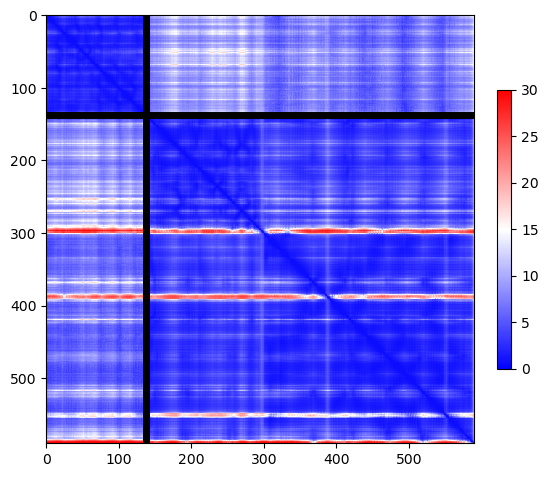

In [13]:

topNum=20#5 #20

color ="lDDT"#"chain" # "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

show_bridge=False#True#False
bridge_type="DCA"
#bridge_type="alphafoldinverseMinDist"
# bridge_type="alphafoldprob12"


show_PAE=True
show_plddt=True


 

pp_list=[("511145.b0965","511145.b2797")
        ]

for p1,p2 in pp_list:

    score_file = f"{colab_outputPath}{p1}and{p2}.custom_unrelaxed_rank_1_model_3_scores.json"
    predicted_aligned_error_file = f"{colab_outputPath}{p1}and{p2}.custom_predicted_aligned_error_v1.json"
    with open(score_file) as json_file:
        pdb_scores = json.load(json_file)

    len1,len2=Query_allPPI_allInfo_dict[(p1,p2)]



    print("ptm:",pdb_scores["ptm"])
    print("p1,p2,len1,len2:",p1,p2,ecoli_proteinNames_dict[p1],ecoli_proteinNames_dict[p2],len1,len2)
    # for k,tem_dict in Ecoli_string_allKindScore_dict.items():
    #     print(k,[tem_dict[(p1,p2)]])

    pdb_file = f"{colab_outputPath}{p1}and{p2}.custom_unrelaxed_rank_1_model_3.pdb"

    PAE_png_file=f"{colab_outputPath}{p1}and{p2}.custom_PAE.png"
    plddt_png_file=f"{colab_outputPath}{p1}and{p2}.custom_plddt.png"

    print(pdb_file)




    view_width=550#300 #600
    view_height=550#300 #600

    plt.figure(figsize=(6,6))
    pdb_view=show_pdb(pdb_file=pdb_file,
             chains=3,  
            # start= start_coords_list[0],
            # end=end_coords_list[1],
             # here 3 works but not 2 , why?, thats because pdb files generated by alphafold
             # always  using chain label starting from chain B , not chain A
             show_sidechains=show_sidechains, 
             show_mainchains=show_mainchains, 
             color=color,
            view_width=view_width,
            view_height=view_height)
    # pdb_view.show()

    if show_bridge:
        if bridge_type =="DCA":
            topRankingBetValue_list=get_topRankingBetValue_dict_PosInSingleMSA((p1,p2,len1,len2,Query_DCA_coevolutoin_path,coevo_suffix),topNum=topNum)
            topRankingBetValue_list=topRankingBetValue_list[2:]

        elif bridge_type=="alphafoldinverseMinDist":

            topRankingBetValue_list=HighDCA_Query_top_alphafoldinverseMinDist_inSingleMSA_dict[(p1,p2)][0:topNum*3]

        elif bridge_type=="alphafoldprob12":
            topRankingBetValue_list=HighDCA_Query_top_alphafoldprob12_inSingleMSA_dict[(p1,p2)][0:topNum*3]


        pro_stuc_chainRes=get_pro_stuc_chainRes_dict(len1,len2,pdb_file)

        start_coords_list,end_coords_list=map_topRankingBetValue_list_to_PDB_CACoords(topRankingBetValue_list,pro_stuc_chainRes)

        pdb_view=py3Dmol_addLines(pdb_view,start_coords_list,end_coords_list,
                                 )

    # pdb_view.zoom(width=640, height=480)
    #pdb_view.zoom(1, 1)
    pdb_view.zoom(1.00)
    pdb_view.show()
    plt.savefig(f"/mnt/mnemo5/tao/temp_figures/{p1}and{p2}_pdb_view.png", dpi=600)




    plt.figure(figsize=(6,6))
    paes_plot =plot_paes_modified(np.array(pdb_scores["pae"]),len1,
                                 dpi=600)
    paes_plot.show()
    # notice , when we show .show(), then save results is empty !!!!
    paes_plot.savefig(f"/mnt/mnemo5/tao/temp_figures/{p1}and{p2}_pae.pdf", dpi=600)



In [14]:
'/mnt/mnemo6/tao/colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve1224/511145.b0965and511145.b2797.custom_unrelaxed_rank_1_model_3_scores.json'

'/mnt/mnemo6/tao/colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve1224/511145.b0965and511145.b2797.custom_unrelaxed_rank_1_model_3_scores.json'

ptm: 0.86
p1,p2,len1,len2: 511145.b0048 511145.b3560 folA glyQ 158 301
/mnt/mnemo6/tao/notebook_data/colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve1224/511145.b0048and511145.b3560.custom_unrelaxed_rank_1_model_3.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<Figure size 640x480 with 0 Axes>

<Figure size 600x600 with 0 Axes>

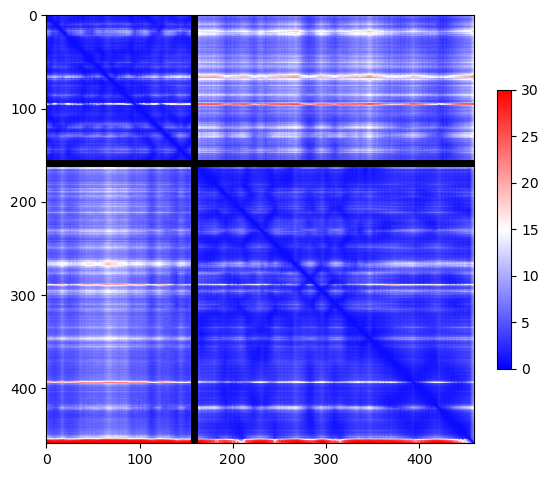

In [15]:

topNum=20#5 #20

color ="lDDT"#"chain" # "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

show_bridge=False#True#False
bridge_type="DCA"
#bridge_type="alphafoldinverseMinDist"
# bridge_type="alphafoldprob12"


show_PAE=True
show_plddt=True


 

pp_list=[("511145.b0048","511145.b3560"),
        ]

for p1,p2 in pp_list:

    score_file = f"{colab_outputPath}{p1}and{p2}.custom_unrelaxed_rank_1_model_3_scores.json"
    predicted_aligned_error_file = f"{colab_outputPath}{p1}and{p2}.custom_predicted_aligned_error_v1.json"
    with open(score_file) as json_file:
        pdb_scores = json.load(json_file)

    len1,len2=Query_allPPI_allInfo_dict[(p1,p2)]



    print("ptm:",pdb_scores["ptm"])
    print("p1,p2,len1,len2:",p1,p2,ecoli_proteinNames_dict[p1],ecoli_proteinNames_dict[p2],len1,len2)
    # for k,tem_dict in Ecoli_string_allKindScore_dict.items():
    #     print(k,[tem_dict[(p1,p2)]])

    pdb_file = f"{colab_outputPath}{p1}and{p2}.custom_unrelaxed_rank_1_model_3.pdb"

    PAE_png_file=f"{colab_outputPath}{p1}and{p2}.custom_PAE.png"
    plddt_png_file=f"{colab_outputPath}{p1}and{p2}.custom_plddt.png"

    print(pdb_file)




    view_width=550#300 #600
    view_height=550#300 #600

    plt.figure(figsize=(6,6))
    pdb_view=show_pdb(pdb_file=pdb_file,
             chains=3,  
            # start= start_coords_list[0],
            # end=end_coords_list[1],
             # here 3 works but not 2 , why?, thats because pdb files generated by alphafold
             # always  using chain label starting from chain B , not chain A
             show_sidechains=show_sidechains, 
             show_mainchains=show_mainchains, 
             color=color,
            view_width=view_width,
            view_height=view_height)
    # pdb_view.show()

    if show_bridge:
        if bridge_type =="DCA":
            topRankingBetValue_list=get_topRankingBetValue_dict_PosInSingleMSA((p1,p2,len1,len2,Query_DCA_coevolutoin_path,coevo_suffix),topNum=topNum)
            topRankingBetValue_list=topRankingBetValue_list[2:]

        elif bridge_type=="alphafoldinverseMinDist":

            topRankingBetValue_list=HighDCA_Query_top_alphafoldinverseMinDist_inSingleMSA_dict[(p1,p2)][0:topNum*3]

        elif bridge_type=="alphafoldprob12":
            topRankingBetValue_list=HighDCA_Query_top_alphafoldprob12_inSingleMSA_dict[(p1,p2)][0:topNum*3]


        pro_stuc_chainRes=get_pro_stuc_chainRes_dict(len1,len2,pdb_file)

        start_coords_list,end_coords_list=map_topRankingBetValue_list_to_PDB_CACoords(topRankingBetValue_list,pro_stuc_chainRes)

        pdb_view=py3Dmol_addLines(pdb_view,start_coords_list,end_coords_list,
                                 )

    # pdb_view.zoom(width=640, height=480)
    #pdb_view.zoom(1, 1)
    pdb_view.zoom(1.00)
    pdb_view.show()
    plt.savefig(f"/mnt/mnemo5/tao/temp_figures/{p1}and{p2}_pdb_view.png", dpi=600)




    plt.figure(figsize=(6,6))
    paes_plot =plot_paes_modified(np.array(pdb_scores["pae"]),len1,
                                 dpi=600)
    paes_plot.show()
    # notice , when we show .show(), then save results is empty !!!!
    paes_plot.savefig(f"/mnt/mnemo5/tao/temp_figures/{p1}and{p2}_pae.pdf", dpi=600)



ptm: 0.74
p1,p2,len1,len2: 511145.b0048 511145.b2797 folA sdaB 158 453
/mnt/mnemo6/tao/notebook_data/colabfold_output/EggNog_1224/511145.b0048and511145.b2797.custom_unrelaxed_rank_1_model_3.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<Figure size 640x480 with 0 Axes>

<Figure size 600x600 with 0 Axes>

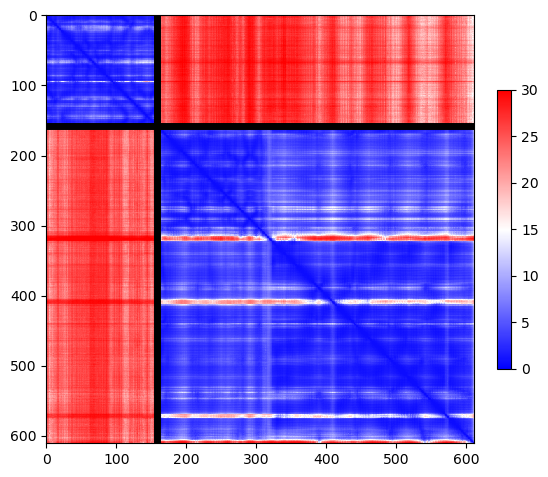

In [16]:
# this one from http://localhost:8206/lab/tree/code/MNF/notebooks/test_alphafold/test_EggNogGenereatedCustomizedMSA_multiplecomplex_deimos.ipynb

test_colab_outputPath=f"{notebookData_folder}colabfold_output/EggNog_1224/"


topNum=20#5 #20

color ="lDDT"#"chain" # "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

show_bridge=False#True#False
bridge_type="DCA"
#bridge_type="alphafoldinverseMinDist"
# bridge_type="alphafoldprob12"


show_PAE=True
show_plddt=True


 

# pp_list=[("511145.b0048","511145.b3560"),
#         ]
# pp_list=[("511145.b0965","511145.b2797")
#         ]

pp_list=[("511145.b0048","511145.b2797"),
        ]


for p1,p2 in pp_list:

    score_file = f"{test_colab_outputPath}{p1}and{p2}.custom_unrelaxed_rank_1_model_3_scores.json"
    predicted_aligned_error_file = f"{test_colab_outputPath}{p1}and{p2}.custom_predicted_aligned_error_v1.json"
    with open(score_file) as json_file:
        pdb_scores = json.load(json_file)

    len1,len2=Query_allPPI_allInfo_dict[(p1,p2)]



    print("ptm:",pdb_scores["ptm"])
    print("p1,p2,len1,len2:",p1,p2,ecoli_proteinNames_dict[p1],ecoli_proteinNames_dict[p2],len1,len2)
    # for k,tem_dict in Ecoli_string_allKindScore_dict.items():
    #     print(k,[tem_dict[(p1,p2)]])

    pdb_file = f"{test_colab_outputPath}{p1}and{p2}.custom_unrelaxed_rank_1_model_3.pdb"

    PAE_png_file=f"{test_colab_outputPath}{p1}and{p2}.custom_PAE.png"
    plddt_png_file=f"{test_colab_outputPath}{p1}and{p2}.custom_plddt.png"

    print(pdb_file)




    view_width=550#300 #600
    view_height=550#300 #600

    plt.figure(figsize=(6,6))
    pdb_view=show_pdb(pdb_file=pdb_file,
             chains=3,  
            # start= start_coords_list[0],
            # end=end_coords_list[1],
             # here 3 works but not 2 , why?, thats because pdb files generated by alphafold
             # always  using chain label starting from chain B , not chain A
             show_sidechains=show_sidechains, 
             show_mainchains=show_mainchains, 
             color=color,
            view_width=view_width,
            view_height=view_height)
    # pdb_view.show()

    if show_bridge:
        if bridge_type =="DCA":
            topRankingBetValue_list=get_topRankingBetValue_dict_PosInSingleMSA((p1,p2,len1,len2,Query_DCA_coevolutoin_path,coevo_suffix),topNum=topNum)
            topRankingBetValue_list=topRankingBetValue_list[2:]

        elif bridge_type=="alphafoldinverseMinDist":

            topRankingBetValue_list=HighDCA_Query_top_alphafoldinverseMinDist_inSingleMSA_dict[(p1,p2)][0:topNum*3]

        elif bridge_type=="alphafoldprob12":
            topRankingBetValue_list=HighDCA_Query_top_alphafoldprob12_inSingleMSA_dict[(p1,p2)][0:topNum*3]


        pro_stuc_chainRes=get_pro_stuc_chainRes_dict(len1,len2,pdb_file)

        start_coords_list,end_coords_list=map_topRankingBetValue_list_to_PDB_CACoords(topRankingBetValue_list,pro_stuc_chainRes)

        pdb_view=py3Dmol_addLines(pdb_view,start_coords_list,end_coords_list,
                                 )

    # pdb_view.zoom(width=640, height=480)
    #pdb_view.zoom(1, 1)
    pdb_view.zoom(1.00)
    pdb_view.show()
    plt.savefig(f"/mnt/mnemo5/tao/temp_figures/{p1}and{p2}_pdb_view.png", dpi=600)




    plt.figure(figsize=(6,6))
    paes_plot =plot_paes_modified(np.array(pdb_scores["pae"]),len1,
                                 dpi=600)
    paes_plot.show()
    # notice , when we show .show(), then save results is empty !!!!
    paes_plot.savefig(f"/mnt/mnemo5/tao/temp_figures/{p1}and{p2}_pae.pdf", dpi=600)



# print detailed informatin of selected protein pairs , for final PPI example 

In [17]:
pp_list=[("511145.b0653","511145.b3269"),
         # ("511145.b0655","511145.b3269"),
         ("511145.b0048","511145.b3560"),
         ("511145.b0965","511145.b2797")
        ]

for p1,p2 in pp_list:

    score_file = f"{colab_outputPath}{p1}and{p2}.custom_unrelaxed_rank_1_model_3_scores.json"
    predicted_aligned_error_file = f"{colab_outputPath}{p1}and{p2}.custom_predicted_aligned_error_v1.json"
    with open(score_file) as json_file:
        pdb_scores = json.load(json_file)

    len1,len2=Query_allPPI_allInfo_dict[(p1,p2)]

    print("p1,p2,len1,len2:",p1,p2,ecoli_proteinNames_dict[p1],ecoli_proteinNames_dict[p2],len1,len2)
    print("ptm:",pdb_scores["ptm"])
    print(STRINGFullPhyBalancePhyla_DCAandLRandRF_dict[(p1,p2)])
    
    
    print("maxAPCedRFPro and its rank",Query_maxAPCedRFProbs_dict[(p1,p2)],sorted_maxAPCedRFProbs_list.index(Query_maxAPCedRFProbs_dict[(p1,p2)]))
    print("max12",Query_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict[(p1,p2)])
    
    try:
        print("string score",Ecoli_string_allKindScore_dict['combined_score'][(p1,p2)])
    except:
        print("no any string score ")
 

p1,p2,len1,len2: 511145.b0653 511145.b3269 gltK yhdX 217 393
ptm: 0.77
[2.022, 0.7156976921090304]
maxAPCedRFPro and its rank 0.3564009563064335 4662
max12 0.99958044
string score 665
p1,p2,len1,len2: 511145.b0048 511145.b3560 folA glyQ 158 301
ptm: 0.86
[1.2386, 0.6601302605060761]
maxAPCedRFPro and its rank 0.256774084315642 15014
max12 0.9895593
no any string score 
p1,p2,len1,len2: 511145.b0965 511145.b2797 yccU sdaB 137 453
ptm: 0.91
[0.9932, 0.6162330352852745]
maxAPCedRFPro and its rank 0.29845982246288444 8944
max12 0.9384556
no any string score 


In [18]:
Ecoli_string_allKindScore_dict.keys()

dict_keys(['neighborhood', 'fusion', 'cooccurence', 'coexpression', 'experimental', 'database', 'textmining', 'combined_score'])

In [19]:
EggNog1224_output_path=f"/mnt/mnemo6/tao/colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve1224/"

EggNog1224_figure_prefiex=""

model_key='model_3'

In [20]:
pp_list=[("511145.b0655","511145.b3269"),
        ]

for p1,p2 in pp_list:
    pp=(p1,p2)
    score_file = f"{colab_outputPath}{p1}and{p2}.custom_unrelaxed_rank_1_model_3_scores.json"
    predicted_aligned_error_file = f"{colab_outputPath}{p1}and{p2}.custom_predicted_aligned_error_v1.json"
    with open(score_file) as json_file:
        pdb_scores = json.load(json_file)

    len1,len2=Query_allPPI_allInfo_dict[(p1,p2)]

    print("p1,p2,len1,len2:",p1,p2,ecoli_proteinNames_dict[p1],ecoli_proteinNames_dict[p2],len1,len2)
    print("ptm:",pdb_scores["ptm"])
    print(STRINGFullPhyBalancePhyla_DCAandLRandRF_dict[(p1,p2)])
    
    argument_toget_interprotein_prob12=[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(pp+Query_allPPI_allInfo_dict[pp])

    interprotein_maxprob12_list=get_interprotein_maxcontactprob_from_processedalphafoldnpz(argument_toget_interprotein_prob12)

    print("maxAPCedRFPro and its rank",Query_maxAPCedRFProbs_dict[(p1,p2)],sorted_maxAPCedRFProbs_list.index(Query_maxAPCedRFProbs_dict[(p1,p2)]))
    print("max12",interprotein_maxprob12_list)
    
    try:
        print("string score",Ecoli_string_allKindScore_dict['combined_score'][(p1,p2)])
    except:
        print("no any string score ")
 

p1,p2,len1,len2: 511145.b0655 511145.b3269 gltI yhdX 282 393
ptm: 0.66
[1.418, 0.5010515032944932]
maxAPCedRFPro and its rank 0.19289716136172885 31710
max12 ('511145.b0655', '511145.b3269', 0.8042737)
string score 365


# final figure 6B: triplet ABC trasporter 
go to http://localhost:8888/lab/tree/proteinStructureSuperPosition.ipynb
and screeenshot to affinity designer 